In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from IPython.display import clear_output
from matplotlib import cm, colors
from sklearn.datasets import fetch_olivetti_faces
from time import sleep

In [2]:
# Create a function which returns a noisy version of the input matrix, with a parameter specifying the probability of pixel corruption
def add_salt_pepper_noise(matrix, prob = 0.1):

    # Generate random noise matrix
    noise = np.random.rand(*matrix.shape)

    # Set salt and pepper probabilities
    salt_prob = prob/2
    pepper_prob = prob/2

    # Add salt and pepper noise
    matrix_with_noise = np.copy(matrix) # Noisy matrix
    noise_mat = np.ones(matrix.shape) * (np.max(matrix)+np.min(matrix))/2 # Noise matrix -- where all other values are midway between corruptions
    matrix_with_noise[noise < salt_prob] = np.max(matrix)
    matrix_with_noise[noise > 1 - pepper_prob] = np.min(matrix)
    noise_mat[noise < salt_prob] = np.max(matrix) # Set salt location corruptions
    noise_mat[noise > 1 - pepper_prob] = np.min(matrix) # Set pepper location corruptions

    return matrix_with_noise, (noise_mat)

### Create robust principal component analysis (RCPA) function using the alternating directions method (ADM) ###
# Code from Brunton & Kutz (2022), https://doi.org/10.1017/9781009089517

# Create shrink function
def shrink(X, tau):
    return np.sign(X) * np.maximum((np.abs(X) - tau), np.zeros(X.shape))

# Create SVT function
def SVT(X, tau):
    U, S, VT = np.linalg.svd(X, full_matrices = 0)
    return np.dot(U, np.dot(np.diag(shrink(S, tau)), VT))

def RPCA__(X, imax = 1000, fthres = 1e-7, verbose = False):

    m, n = X.shape # Store matrix dimensions
    mu = m*n / (4*np.sum(np.abs(X.reshape(-1)))) # Calculate mu
    lambd = 1 / np.sqrt(np.max([m,n])) # Calculate lambda
    thres = fthres * np.linalg.norm(X) # Determine threshold (tolerance)

    # Initiate matrices S, Y & L
    S = np.zeros_like(X) 
    Y = np.zeros_like(X)
    L = np.zeros_like(X)

    err = np.inf
    count = 0
    # Continue iterating while X ≈ L + S is below threshold or maximum number of iterations has been reached
    while (err > thres) and (count < imax) :


        # Update L, S & Y
        L = SVT(X - S + 1/mu * Y, 1/mu)
        S = shrink(X - L + 1/mu * Y, lambd/mu)
        Y = Y + mu * (X - L - S)

        if verbose and count % 5 == 0 :
            clear_output(wait = True)
            prog = thres/err
            bar = '|' + round(20*prog)*'/' + (20 - round(20*prog)) * '_' + '|'
            print(f'... {round(prog, 3)} ---> 1.0 ... {bar} ... ({count}/{imax}) ...')

        # Update count and error
        count += 1
        err = np.linalg.norm(X - L - S, ord = 'fro')


    # Print number of iterations required
    if verbose:
        clear_output()
        if count == imax:
            print(f'No convergence after {count} iterations')
        else:
            print(f'Solution found after {count} iterations')

    return L, S

In [7]:
# Load sklearn digits dataset, X
X = load_digits().data
# Normalize matrix data between 0 and 1
X = X / np.max(X)

# Add noise as normally distributed noise
nX = X + np.random.normal(0, .1, X.shape)

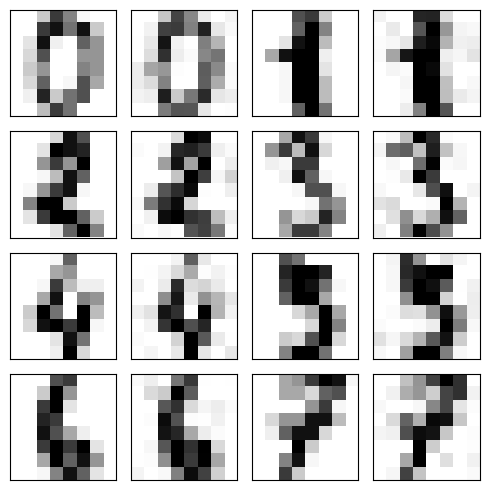

In [8]:
# Create a figure showing the original images and their corrupted versions
fig, axs = plt.subplots(4, 4, figsize = (5,5))
i, f = 0, 0
for m in range(4):
    for n in range(4):

        if i % 2 == 0:
            # Show original image
            im = axs[m,n].imshow(X[f].reshape(8,8), cmap = 'Greys', vmin = 0, vmax = 1)
        else:
            # Show corrupted version
            im = axs[m,n].imshow(nX[f].reshape(8,8), cmap = 'Greys', vmin = 0, vmax = 1)
            f += 1
        axs[m,n].set_xticks([]); axs[m,n].set_yticks([])
        i += 1

plt.tight_layout()
plt.show()

In [9]:
# Perform robust PCA on the digits-matrix
L, S = RPCA(nX, imax = 1000, verbose = True)

Solution found after 296 iterations


ValueError: cannot reshape array of size 4096 into shape (8,8)

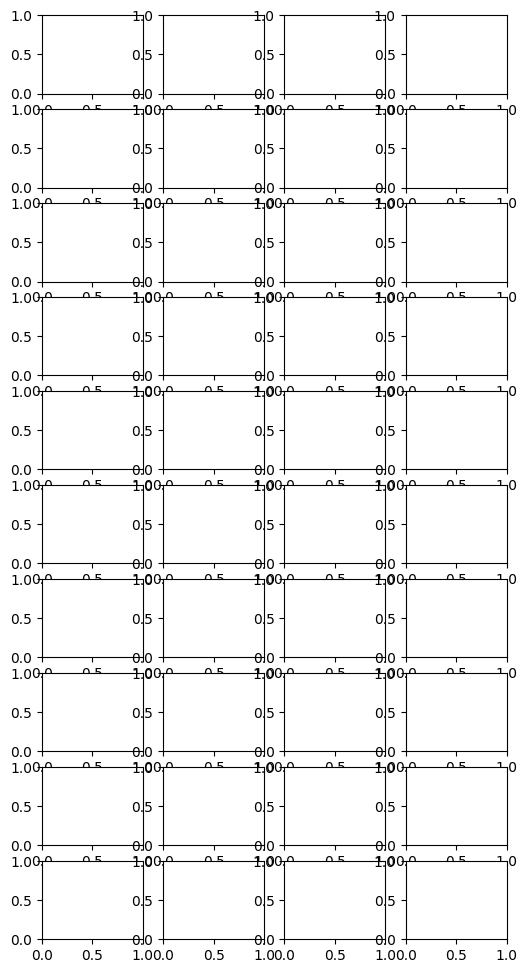

In [17]:
# For each of the first 10 digits of the dataset: plot X, nX, L & S
fig, axs = plt.subplots(10, 4, figsize = (6, 12))
cmap = 'Greys'

for k in range(10):
    sleep(1)
    axs[k,0].imshow(X[k].reshape(8,8), cmap = cmap, vmin = np.min(nX), vmax = np.max(nX))
    axs[k,1].imshow(nX[k].reshape(8,8), cmap = cmap, vmin = np.min(nX), vmax = np.max(nX))
    axs[k,2].imshow(L[k].reshape(8,8), cmap = cmap, vmin = np.min(nX), vmax = np.max(nX))
    im = axs[k,3].imshow(S[k].reshape(8,8), cmap = cmap, vmin = np.min(nX), vmax = np.max(nX))

    for i in range(4):
        axs[k,i].set_xticks([])
        axs[k,i].set_yticks([])

    if k == 0:
        axs[k,0].set_title('Original image', size = 10)
        axs[k,1].set_title('Noisy image', size = 10)
        axs[k,2].set_title('Low-rank matrix', size = 10)
        axs[k,3].set_title('Sparse matrix', size = 10)

plt.tight_layout()
#plt.savefig('Figures/RPCA_digits_greycmap.jpeg', dpi = 400)
plt.show()

In [3]:
# Load sklearn faces dataset, X
X = fetch_olivetti_faces().data
# Call the user-defined function to add salt-and-pepper noise to the images
nX, n = add_salt_pepper_noise(X, prob = 0.15)

In [11]:
# Perform RPCA on matrix X
L, S = RPCA(nX, imax = 1000, fthres = 1e-7, verbose = True)

Solution found after 256 iterations


In [18]:
# For 10 random images in the dataset: plot X, nX, L & S
fig, axs = plt.subplots(10, 4, figsize = (6, 12))
cmap = 'Greys'

for ki, k in enumerate(np.random.randint(0, X.shape[0], 10)) :
    sleep(1)
    axs[ki,0].imshow(X[k].reshape(64,64), cmap = cmap, vmin = 0, vmax = 1)
    axs[ki,1].imshow(nX[k].reshape(64,64), cmap = cmap, vmin = 0, vmax = 1)
    axs[ki,2].imshow(L[k].reshape(64,64), cmap = cmap, vmin = 0, vmax = 1)
    im = axs[ki,3].imshow(S[k].reshape(64,64), cmap = cmap, vmin = 0, vmax = 1)

    if ki == 0:
        axs[ki,0].set_title('Original image', size = 10)
        axs[ki,1].set_title('Noisy image', size = 10)
        axs[ki,2].set_title('Low-rank matrix', size = 10)
        axs[ki,3].set_title('Sparse matrix', size = 10)


    for i in range(4):
        axs[ki,i].set_xticks([])
        axs[ki,i].set_yticks([])


plt.tight_layout()
#plt.savefig('Figures/RPCA_faces_greycmap.jpeg', dpi = 400)
plt.show()

In [227]:
# Let's now run RPCA with a varying amount of noise -- to see how it impacts the number of iterations and |X - L|
noise_probs = np.linspace(0, 0.5, 20)

# Load sklearn digits dataset, X
X = fetch_olivetti_faces().data

X_nX_norm = []; X_L_norm = []; iters = []
for prob in noise_probs:
    print(prob)
    # Add salt and pepper noise
    nX, _ = add_salt_pepper_noise(X, prob = prob)
    # Perform RPCA
    L, S, I = RPCA(nX, imax = 500, fthres = 1e-4, verbose = True)

    # Store number of iterations and distance between nX and X & between X and L 
    iters.append(I)
    X_nX_norm.append(np.linalg.norm(X - nX))
    X_L_norm.append(np.linalg.norm(X - L))
    clear_output(wait = True)

Solution found after 95 iterations


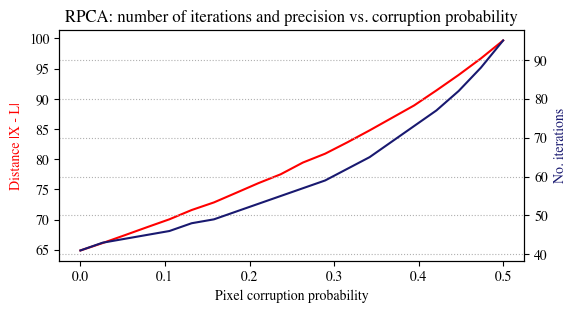

In [287]:
# Plot the number of iterations and the distance between the original and low-rank matrices wrt. the corruption probability
plt.rcParams['font.family'] = 'times'
fig, ax1 = plt.subplots(figsize = (6, 3))
ax2 = ax1.twinx()

ax1.plot(noise_probs, X_L_norm, label = '|X - L|', c = 'red')
ax1.set_ylabel('Distance |X - L|', color = 'red')
ax2.plot(noise_probs, iters, label = 'No. iterations', c = 'midnightblue')
ax2.set_ylabel('No. iterations', color = 'midnightblue')

ax2.grid(axis = 'y', linestyle = ':')

ax1.set_xlabel('Pixel corruption probability')

plt.title('RPCA: number of iterations and precision vs. corruption probability')
plt.savefig('Figures/RPCA_vs_corruption.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [4]:
rpca = RPCA(X)

NameError: name 'RPCA' is not defined

In [30]:
from rpca import *

In [31]:
rpca = RPCA(X)

In [32]:
rpca.fit(verbose = True)

TypeError: RPCA.shrink() takes 2 positional arguments but 3 were given

In [28]:
rpca.shrink(X, 0)

TypeError: RPCA.shrink() takes 2 positional arguments but 3 were given

In [29]:
X

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)